In [2]:
import numpy as np

In [3]:
# Patrick script

# Input: Takes in the GML file 
# Output: A Dictionary indexed by Building Identification with attributes
#         X (min, max), Y (min, max), Z (min, max), BIN, DOITT_ID, SOURCE_ID
def parse(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id]["X"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Y"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Z"] = [float("inf"),-float("inf")]
            current = bldg_id
        if "/bldg:Building" in line:
            current = None
        if "BIN" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['BIN'] = bld_id
        if "DOITT_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['DOITT_ID'] = bld_id
        if "SOURCE_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['SOURCE_ID'] = bld_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                if x > buildings[bldg_id]["X"][1]:
                    buildings[bldg_id]["X"][1] = x
                if x < buildings[bldg_id]["X"][0]:
                    buildings[bldg_id]["X"][0] = x
                if y > buildings[bldg_id]["Y"][1]:
                    buildings[bldg_id]["Y"][1] = y
                if y < buildings[bldg_id]["Y"][0]:
                    buildings[bldg_id]["Y"][0] = y
                if z > buildings[bldg_id]["Z"][1]:
                    buildings[bldg_id]["Z"][1] = z
                if z < buildings[bldg_id]["Z"][0]:
                    buildings[bldg_id]["Z"][0] = z
    return buildings

In [4]:
# Input: Takes in the GML file 
# Output: A dictionary with key = Building Identification (e.g. Bldg_12210009096) 
#         and value = [(X1, Y1, Z1), (X2, Y2, Z2), etc.] for each polygon that makes up the building
def parseAllCoordinates(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id] = []
            current = bldg_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            polygon = []
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                polygon.append((x,y,z))
            buildings[current].append(polygon)
        if "/bldg:Building" in line:
            current = None
                
    return buildings

In [5]:
# Makes homography to map from coordinate system to Latitude/Longitude
# Just for the 12th GML File 
def train_homography(dictionary):
	# Manually measured latitude and longitude for 5 buildings
	new_lat_long = np.array([[40.712994,74.013227], [40.748629,73.985807],[40.751655,73.975488],[40.702138,74.012065],[40.769110,73.981620]])

	# Test Buildings in Coordinate System
	One_World_Trade = dictionary['Bldg_21510003972']
	Empire_State = dictionary['Bldg_12210009096']
	Chrysler = dictionary['Bldg_12210010508']
	New_York_Plaza = dictionary['Bldg_21210000601']
	Trump_Int = dictionary['Bldg_12210018998']

	# Build Source Points
	Buildings = [One_World_Trade, Empire_State, Chrysler, New_York_Plaza, Trump_Int]
	src_data = [[(i['X'][0]+i['X'][1])/2,(i['Y'][0]+i['Y'][1])/2] for i in Buildings]

	# Compute Homography
	H = compute_homography(np.matrix(src_data),new_lat_long)
	return H 

In [6]:
# From Homework 4
def apply_homography(src, H):
    # Applies a homography H onto the source points, src.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     H: homography from source points to destination points, shape (3, 3)
    # Output:
    #     dst: destination points, shape (n, 2)
    final = np.zeros_like(src)
    for i in range(len(src)):
        transform = np.append(src[i],[[1]],1)
        result = np.dot(H,transform.T)
        result /= result[2]
        final[i] = result.T[:,:2]
    return final

In [7]:
# From Homework 4
def compute_homography(src, dst):
    # This function computes the homography from src to dst.
    #
    # Input:
    #     src: source points, shape (n, 2)
    #     dst: destination points, shape (n, 2)
    # Output:
    #     H: homography from source points to destination points, shape (3, 3)
    
    A = np.zeros([2*src.shape[0], 9])
    for i in range(src.shape[0]):
        A[2*i, :] = np.array([src[i,0],src[i,1],1,0,0,0,
                              -dst[i,0]*src[i,0],-dst[i,0]*src[i,1],-dst[i,0]])
        A[2*i+1, :] = np.array([0,0,0,src[i,0],src[i,1],1,
                                -dst[i,1]*src[i,0],-dst[i,1]*src[i,1],-dst[i,1]])
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H

In [8]:
GML_file = '/Users/mogryzko/Desktop/nyc-visual-building-annotator/DA12_3D_Buildings_Merged.gml'

building_pts = parse(GML_file)
building_polys = parseAllCoordinates(GML_file)
print(len(building_polys))



24039


In [9]:
H = train_homography(building_pts)
# Test Case: This is the Castle Clinton National Monument
#test = building_pts['Bldg_12210022273']
# Empire state building test
test = building_pts['Bldg_12210009096']
#print(np.matrix([(test['X'][0]+test['X'][1])/2,(test['Y'][0]+test['Y'][1])/2]))
print(apply_homography(np.matrix([(test['X'][0]+test['X'][1])/2,(test['Y'][0]+test['Y'][1])/2]),H))

[[40.74847984 73.9858314 ]]


In [10]:
print(apply_homography(np.matrix([40.7664542, -73.9767703]),np.linalg.inv(H)))

[[122872.51881295 214119.49784516]]


In [11]:
H_to_gml_coor = np.linalg.inv(H)

In [12]:
def rotation_matrix(x,y,z):
    # x,y,z = 0 when phone is flat on table with top facing east 
    # normalize from -1 to 1 to 0 to 2pi
    
    theta = x,y,z
    
    theta = [axis % 2 * np.pi for axis in theta]
    
    
    R_x = np.array([[1,               0,                0],
                    [0,np.cos(theta[0]),-np.sin(theta[0])],
                    [0,np.sin(theta[0]), np.cos(theta[0])]
                    ])
                     
    R_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                    [0,                   1,          0             ],
                    [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                    ])
                 
    R_z = np.array([[np.cos(theta[2]),  -np.sin(theta[2]),    0],
                    [np.sin(theta[2]),   np.cos(theta[2]),    0],
                    [0,                     0,                1]
                    ])
                     
                     
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

In [13]:
def translation_vector(lat,long,alt,H):
    x = int(apply_homography(np.matrix([lat, long]),H)[0,0])
    y = int(apply_homography(np.matrix([lat, long]),H)[0,1])
    T = np.array([[x],[y],[-alt]])
    return T

In [50]:
def camera_matrix(R,T, focal_len, pixel_size, center_x, center_y): 
    fx = focal_len/pixel_size
    fy = focal_len/pixel_size
    intrinsic_matrix = np.array([[fx,0,center_x],
                            [0,fy,center_y],
                            [0,0,1]])
    extrinsic_matrix = np.append(R,T,axis=1)
    camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
    return camera_matrix


In [143]:
def extract(s):
    pixel_size = s[s.find('PixelSizeMm') + 13:]
    pixel_size = float(pixel_size[:pixel_size.find(' ')])
    #edit
    pixel_size = 0.00122
    focal_length = s[s.find('FocalMm') + 9:]
    focal_length = float(focal_length[:focal_length.find('"')])
    #edit
    focal_length = 25
    fx = focal_length/pixel_size
    fy = focal_length/pixel_size
    intrinsic_matrix = np.array([[fx,0,445],
                            [0,fy,295],
                            [0,0,1]])
    rotation_matrix = s[s.find('RotationMatrix') + 16:]
    rm = [float(i) for i in rotation_matrix[:rotation_matrix.find('"')].split(' ')[:-1]]
    R = np.array([rm[:3],rm[4:7],rm[8:11]])
    #edit
    #R = np.linalg.inv(R)
    translation_vector = s[s.find('TranslationVector') + 19:]
    T = np.array([[float(i)] for i in translation_vector[:translation_vector.find('"')].split(' ')[:-1]])
    extrinsic_matrix = np.append(R,T,axis=1)

    camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
    return camera_matrix

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def projection(H,bldg_id,x,y,z,lat,long,alt=77.6,focal_length=29,pixel_size=0.00122,view_x = 3024,view_y = 4032):
    center_x,center_y = view_x//2, view_y//2

    R = rotation_matrix(x,y,z)
    
    T = translation_vector(lat,long,alt,H)
    x_offset,y_offset,z_offset = T[0],T[1],T[2]
    T = np.array([[0], [0], [0]])

    C = camera_matrix(R, T, focal_length, pixel_size, center_x, center_y)

    twoD_pts = []
    for polygon in building_polys[bldg_id]:
        poly_pts = np.zeros((len(polygon),2))
        for idx, pt in enumerate(polygon):
            pt = np.array(pt)
            pt[0] -= x_offset
            pt[1] -= y_offset
            pt[2] -= z_offset
            new_pt = np.append(pt,np.array([1]), axis=0)
            new_pt = np.matmul(C,new_pt)
            new_pt = new_pt[:2]/new_pt[2]
            poly_pts[idx] = new_pt
        twoD_pts.append(poly_pts)

    new_img = np.zeros((view_y, view_x))
    for poly in twoD_pts:
        poly = poly.astype(int)
        for pt in poly:
            if not(0 < pt[0] < view_x) and not(0 < pt[1] < view_y):
                continue
        cv2.fillPoly(new_img, pts=[poly], color=(255,255,255))
    flipped_new = np.fliplr(new_img)
    nonzero = cv2.findNonZero(flipped_new.astype('uint8'))
    nonzero = nonzero.reshape((nonzero.shape[0],nonzero.shape[2]))
    final = flipped_new[np.min(nonzero[:,1]):np.max(nonzero[:,1]),np.min(nonzero[:,0]):np.max(nonzero[:,0])]
    return final

In [122]:
extract('''<!DOCTYPE ViewState>
<project>
 <VCGCamera RotationMatrix="0.897064 -0.441798 -0.00952429 0 0.0776641 0.136405 0.987604 0 -0.435022 -0.886684 0.156676 0 0 0 0 1 " ViewportPx="977 590" CameraType="0" PixelSizeMm="0.0369161 0.0369161" LensDistortion="0 0" FocalMm="18.8625" CenterPx="488 295" TranslationVector="-987285 -209991 -614.687 1"/>
 <ViewSettings NearPlane="0.909327" FarPlane="81.6353" TrackScale="0.00142562"/>
</project>
''')

[[ 0.897064   -0.441798   -0.00952429]
 [ 0.0776641   0.136405    0.987604  ]
 [-0.435022   -0.886684    0.156676  ]]
[[-9.87285e+05]
 [-2.09991e+05]
 [-6.14687e+02]]


array([[ 1.83824590e+04, -9.05323770e+03, -1.95169877e+02,
        -2.02312500e+10],
       [ 1.59147746e+03,  2.79518443e+03,  2.02377869e+04,
        -4.30309426e+09],
       [-4.35022000e-01, -8.86684000e-01,  1.56676000e-01,
        -6.14687000e+02]])

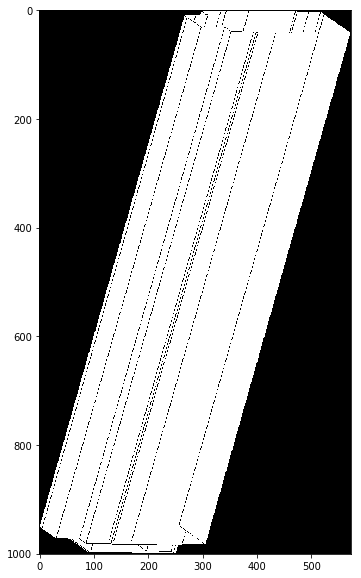

In [94]:
# Testing getting more detail from the building


import numpy as np
import matplotlib.pyplot as plt
import cv2

# trump tower building
bldg_id = 'Bldg_12210018998'

#Trump tower last picture (pic 5)
x = 0.59157
y = -0.59825
z = -0.33803
lat = 40.7686776
long = -73.9815132
alt = 70 #guess based on meshlab
focal_length = 25
pixel_size = 0.00122

'''
R = rotation_matrix(x,y,z)
#T = translation_vector(lat,long,alt,H_to_gml_coor)
T = np.array([[--989945], [-219059], [-817.984]])
'''

R = np.array([[0.421304, 0.906849, 0.0112592], [0.486668, -0.236538, 0.840955], [0.765282, -0.348819, -0.540989]]) 

T = np.array([[-990086],[-219136],[301.662]])



C = camera_matrix(R, T, focal_length, pixel_size)

total_num_pts = 0
for polygon in building_polys[bldg_id]:
    total_num_pts += len(polygon)

all_2D_pts = np.zeros((total_num_pts,2)) # for np.max and np.min


twoD_pts = []
all_idx = 0
for polygon in building_polys[bldg_id]:
    poly_pts = np.zeros((len(polygon),2))
    for idx, pt in enumerate(polygon):
        new_pt = np.append(np.array(pt),np.array([1]), axis=0)
        new_pt = np.matmul(C,new_pt)
        new_pt = new_pt[:2]/new_pt[2]
        poly_pts[idx] = new_pt
        all_2D_pts[all_idx] = new_pt #for np.max and np.min
        all_idx += 1
    twoD_pts.append(poly_pts)
    
max_x = np.max(all_2D_pts[:,0])
min_x = np.min(all_2D_pts[:,0])
max_y = np.max(all_2D_pts[:,1])
min_y = np.min(all_2D_pts[:,1])

# adjust pts to fit within window

if min_x < 0:
    for poly in twoD_pts:
        poly[:,0] -= min_x
    all_2D_pts[:,0] -= min_x
if min_y < 0:
    for poly in twoD_pts:
        poly[:,1] -= min_y
    all_2D_pts[:,1] -= min_y

max_x = np.max(all_2D_pts[:,0])
min_x = np.min(all_2D_pts[:,0])
max_y = np.max(all_2D_pts[:,1])
min_y = np.min(all_2D_pts[:,1])



scale = (max_y-min_y) / 1000

new_img = np.zeros((1001, int((max_x-min_x)/scale)+1))

for idx,poly in enumerate(twoD_pts):
    poly[:,0] -= min_x
    poly[:,0] /= scale
    poly[:,1] -= min_y
    poly[:,1] /= scale
    twoD_pts[idx] = poly.astype(int)


for poly in twoD_pts:
    poly = np.int32(poly)
    #cv2.polylines(new_img,[poly],False,(255,255,255))
    cv2.fillPoly(new_img, pts=[poly], color=(255,255,255))
    cv2.polylines(new_img,[poly],1,(0,255,255))

      
plt.figure(figsize=(20,10))

plt.imshow(new_img,cmap='gray')
plt.show()